# Put TRAIN, TEST AND CLASSES inside of pickle file

mnist
../PytorchDatasets/MyDatasets/mnist/mnist.pickle


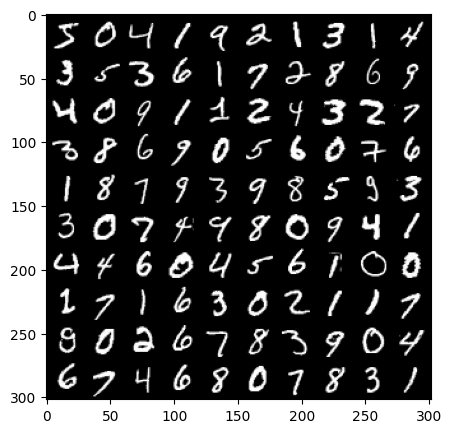

cifar10
../PytorchDatasets/MyDatasets/cifar10/cifar10.pickle


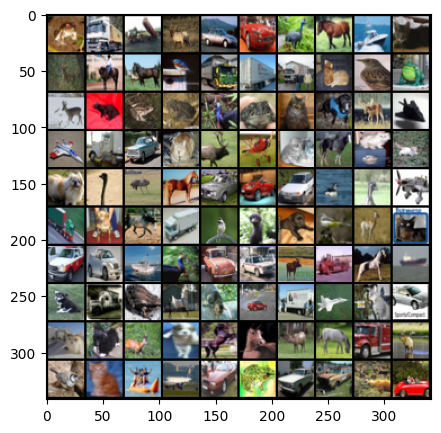

cifar100
../PytorchDatasets/MyDatasets/cifar100/cifar100.pickle


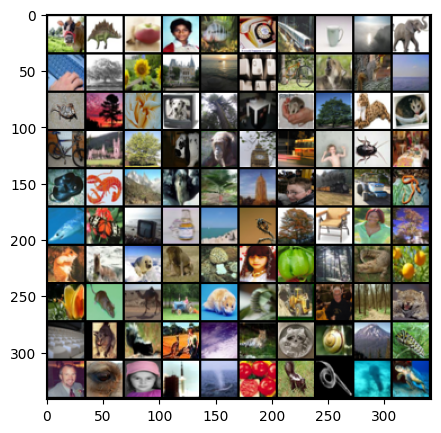

In [17]:
import torch
import torchvision
from filelock import FileLock
import os
from natsort import natsorted
import sys

import pickle
import glob
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def show_tensor(x, fs=5, grid_nrow=None):
    if grid_nrow != None:
        if grid_nrow == 0:
            grid_nrow = int(x.shape[0]**0.5)
        x = torchvision.utils.make_grid(x.cpu().clone(), nrow=grid_nrow)
    
    plt.figure(figsize=(fs, fs))
    x_show = torch.permute(x, (1, 2, 0))
    plt.imshow(x_show)
    plt.show()


def pickle_save(file, item):
    with open(file, 'wb') as fp:
        pickle.dump(item, fp)


def pickle_safe_load(file):
    with FileLock(f'{file}.lck'):
        with open(file, 'r+b') as pfile:
            data = pickle.load(pfile)
            return data
        
        
def extract_data_and_targets_from_dataset(ds):
    data = ds.data
    targets = ds.targets

    # Convert to tensor and permute because is numpy
    if not isinstance(data, torch.Tensor):
        data = torch.tensor(data)
        data = torch.permute(data, (0, 3, 1, 2))
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.tensor(targets).to(torch.int64)
        
    return data, targets


# Carefull needs parameters to be changed
def save_dataset_into_pickle(root_dir, dataset_name):
    dataset_dict = {
        "mnist": torchvision.datasets.MNIST,
        "fashionmnist": torchvision.datasets.FashionMNIST,
        "cifar10": torchvision.datasets.CIFAR10,
        "cifar100": torchvision.datasets.CIFAR100,
        "svhn": torchvision.datasets.SVHN,
    }
    
    if dataset_name in ["mnist", "fashionmnist", "cifar10", "cifar100"]:
        ds_train = dataset_dict[dataset_name]("../../PytorchDatasets", download=False, train=True)
        data_train, targets_train = extract_data_and_targets_from_dataset(ds_train)
        ds_train_dict = {"data": data_train, "targets": targets_train}

        ds_test = dataset_dict[dataset_name]("../../PytorchDatasets", download=False, train=False)
        data_test, targets_test = extract_data_and_targets_from_dataset(ds_test)
        ds_test_dict = {"data": data_test, "targets": targets_test}
    
    if dataset_name in ["svhn"]:
        ds_train = dataset_dict[dataset_name]("../../PytorchDatasets", download=False, split="train")
        data_train, targets_train = ds_train.data, ds_train.labels
        data_train, targets_train = torch.tensor(data_train), torch.tensor(targets_train)
        ds_train_dict = {"data": data_train, "targets": targets_train}
        
        ds_extra = dataset_dict[dataset_name]("../PytorchDatasets", download=False, split="extra")
        data_extra, targets_extra = ds_extra.data, ds_extra.labels
        data_extra, targets_extra = torch.tensor(data_extra), torch.tensor(targets_extra)
        ds_extra_dict = {"data": data_extra, "targets": targets_extra}
        
        data_train = torch.cat((data_train, data_extra))
        targets_train = torch.cat((targets_train, targets_extra))
        
        ds_test = dataset_dict[dataset_name]("../PytorchDatasets", download=False, split="test")
        data_test, targets_test = ds_test.data, ds_test.labels
        data_test, targets_test = torch.tensor(data_test), torch.tensor(targets_test)
        ds_test_dict = {"data": data_test, "targets": targets_test}
        
        ds_train.classes = torch.arange(0, 10)
        
    ds_dict={
        "train": ds_train_dict,
        "test": ds_test_dict,
        "classes": ds_train.classes
    }

    ds_dir = os.path.join(root_dir, "", ds_name)
    os.makedirs(ds_dir, exist_ok=True)
    ds_file_path=""f"{ds_dir}/{dataset_name}.pickle"
    print(ds_file_path)
    pickle_save(ds_file_path, ds_dict)
  

    
def extract_data_from_ds_dict(ds_dict):
    if "data" in ds_dict.keys():
        data, targets = ds_dict["data"], ds_dict["targets"]
    else:
        data, targets = ds_dict["x"], ds_dict["y"]
    return data, targets


root_dir = "../PytorchDatasets/MyDatasets/"
os.makedirs(root_dir, exist_ok=True)

ds_name_arr = ["mnist", "cifar10", "cifar100"]
for ds_name in ds_name_arr:
    print(ds_name)
    save_dataset_into_pickle(root_dir, ds_name)
    
    test_ds_file = f"{root_dir}/{ds_name}/{ds_name}.pickle"
    ds = pickle_safe_load(test_ds_file)
    x_train = ds["train"]["data"]
    k=100
    x_train_k = x_train[:k]

    if len(x_train_k.shape) < 4:
        x_train_k = x_train_k.unsqueeze(1) # Add channel dimension for mnist


    show_tensor(x_train_k, fs=5, grid_nrow=0)
